Change from v1

- Change to demand, now with a deque and weekly deliveries and not every day
- Change to action space --> safety stock level

**Importing Dependencies**

In [1]:
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import pygame
import pygame.gfxdraw

import networkx as nx

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
# Probably not needed --> test ray lib instead
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

**Building the environment**

In [2]:
EP_LENGTH = 30 # Length of the episode

class SS_Mngmt_Env(Env):

    metadata = {"render_modes": ["human"], "render_fps": 4}
    
    # Define the action and observation space
    def __init__(self, render_mode = None):

        # To implement
        # storage capacities
        # campaign size
        # safety stock

        self.episode_length = EP_LENGTH # Length of the episode

        self.I = 30 # Initial stock level

        # Demand
        self.planned_demand = [0, 0, 0, 0, 0, 15,
                                0, 0, 0, 0, 0, 15,
                                0, 0, 0, 0, 0, 15,
                                0, 0, 0, 0, 0, 15,
                                0, 0, 0, 0, 0, 15
                                ]
        
        self.expected_demand = 0 # Expected demand for production

        # self.actual_demand = 6 # Actual demand for production

        # Costs
        self.c_fixed = 50 # Fixed costs for ordering
        self.c_variable = 1 # Variable costs for ordering per unit
        self.p = 1 # Cost for storing each item
        self.stockout_cost = 1000 # Cost of stockout

        # Order delay and queue
        self.lead_time = 3
        self.order_queue = deque(maxlen = self.lead_time)

        self.delivered = 0  # Delivered stock
        
        # Define action space
        # Change the action space for different campaign sizes
        # 1. Order Size
        # self.action_space = Box(low = np.array([0]), 
        #                              high = np.array([10]),
        #                              dtype = np.int64)
        self.action_space = Discrete(10)
        
        # Define observation space (Stock level) --> to add expected demand, etc.
        # 1. Stock Level
        # 2. Expected Demand at timestep t + lead time
        self.observation_space = Box(low = np.array([0, 0]), 
                                     high = np.array([100, 20]),
                                     dtype = np.int64)

        # Define the initial state
        self.state = np.array([self.I, self.expected_demand])

        # History
        self.reward_history = []
        self.stock_history = []
        self.demand_history = []
        self.expected_demand_history = []
        self.order_history = []
        self.delivery_history = []

        # Empty dataframe for plotting the history and analysis
        self.history = pd.DataFrame(columns = ['Stock Level', 'Order', 'Demand'])

        # Render mode
        self.render_mode = render_mode
        self.screen_initialized = False


    # Defining the step function
    def step(self, action):
        # Returns the next state, reward and whether the episode is done

        # To Do: Campaign Size
        # To Do: Demand can only be fullfilled if sufficient stock is available demand is then placed in the backlog queue

        # Expected demand for production at timestep t + lead time
        i = EP_LENGTH - self.episode_length
        if i + self.lead_time < len(self.planned_demand):
            self.state[1] = self.planned_demand[i + self.lead_time]

        # Demand for the current timestep
        if self.planned_demand[i] > 0:
            self.demand = self.planned_demand[i] + random.randint(-1, 1)
        else:
            self.demand = 0

        # Subtract the demand from the stock
        self.state[0] = self.state[0] - self.demand

        # If there are enough steps passed since the order was placed, add the order to the stock
        if len(self.order_queue) == self.lead_time:
            self.delivered = self.order_queue.popleft()
            self.state[0] += self.delivered
        
        # Add the order to the queue
        self.order_queue.append(action)

        # Calculate the reward based on order costs
        if action > 0:
            reward = - self.c_fixed - self.c_variable * action
        else:
            reward = 0

        # Check if the stock level is negative
        if self.state[0] <= 0:
            # If the stock level is negative, the cost is the stockout cost
            reward -=  self.stockout_cost
        else:
            # If the stock level is positive, the cost is the stock level
            reward -= self.state[0]

        # Calculate the cost of the stock
        # Reward is negative since we want to minimize the cost
        # reward = float(reward - (self.state))

        # Check if the episode is done
        done = self.episode_length == 0

        # Decrease the episode length
        self.episode_length -= 1

        obs = np.array([self.state[0], self.state[1]])

        # Append the state to the history
        self.reward_history.append(reward)
        self.stock_history.append(self.state[0])
        self.order_history.append(action)
        self.demand_history.append(self.demand)
        self.expected_demand_history.append(self.state[1])
        self.delivery_history.append(self.delivered)

        # Check if episode is done
        if self.episode_length <= 0: 
            done = True
        else:
            done = False

        # Set placeholder for info
        info = {}

        # Check if the episode is truncated
        truncated = False

        return obs, float(reward), done, truncated, info

    def render(self):
        # Just check episode lenghth and only plot the last one when using matplotlib          
        if self.render_mode is not None:
            if self.render_mode == "human":
                self.render_human()
                # self.render_pygame()

    def render_human(self):

        # To Do
        # Actual vs. Expected Demand

        # Create a list of timestamps for the order history
        timestamps = np.arange(len(self.order_history))

        # Setting up the plot
        fig, ax = plt.subplots(3, 2, figsize=(12, 9)) # 1 row and 2 columns
        bar_width = 0.35
        
        # Plotting the stock level
        ax[0, 0].plot(self.stock_history, color = 'blue', label = 'Stock Level')
        ax[0, 0].set_ylabel('Stock Level')
        # ax[0, 0].set_xlabel('Time')
        ax[0, 0].set_title('Stock Level vs. Time')
        ax[0, 0].set_xticks(np.arange(0, 30, step=5))
        ax[0, 0].set_yticks(np.arange(0, 100, step=10))

        # Plotting the order, delivered and demand
        ax[1, 0].bar(timestamps - bar_width, self.order_history, bar_width, color='blue', alpha = 0.5, label='Order')
        ax[1, 0].bar(timestamps, self.delivery_history, bar_width, color='red', alpha = 0.5, label='Delivery')
        ax[1, 0].bar(timestamps + bar_width, self.demand_history, bar_width, color='green', alpha=0.5, label='Demand')
        ax[1, 0].set_ylabel('Order/Delivery/Demand')
        ax[1, 0].set_title('Order vs. Delivery vs. Demand')
        ax[1, 0].set_xticks(np.arange(0, 30, step=5))
        ax[1, 0].legend(['Order', 'Delivery', 'Demand'])

        # Plotting the reward per timestep
        ax[0, 1].plot(self.reward_history, color = 'purple', label = 'Reward')
        ax[0, 1].set_ylabel('Reward')
        # ax[0, 1].set_xlabel('Time')
        ax[0, 1].set_title('Reward vs. Time')
        ax[0, 1].set_xticks(np.arange(0, 30, step=5))

        # Plotting the accumulated reward
        ax[1, 1].plot(np.cumsum(self.reward_history), color = 'orange', label = 'Accumulated Reward')
        ax[1, 1].set_ylabel('Accumulated Reward')
        # ax[1, 1].set_xlabel('Time')
        ax[1, 1].set_title('Accumulated Reward vs. Time')
        ax[1, 1].set_xticks(np.arange(0, 30, step=5))

        import numpy as np

        # Plotting the expected demand and actual demand
        # Shift the expected demand by 3 timesteps
        # shifted_expected_demand = np.roll(self.expected_demand_history, 3)

        # ax[2, 0].plot(shifted_expected_demand, color = 'blue', label = 'Expected Demand')
        # ax[2, 0].plot(self.demand_history, color = 'green', label = 'Actual Demand')
        # ax[2, 0].set_ylabel('Demand')
        # ax[2, 0].set_title('Expected vs. Actual Demand')
        # ax[2, 0].set_xticks(np.arange(0, 30, step=5))

        # Plotting the expected demand and actual demand
        ax[2, 0].plot(self.expected_demand_history, color = 'blue', label = 'Expected Demand')
        ax[2, 0].plot(self.demand_history, color = 'green', label = 'Actual Demand')
        ax[2, 0].set_ylabel('Demand')
        ax[2, 0].set_title('Expected vs. Actual Demand')
        ax[2, 0].set_xticks(np.arange(0, 30, step=5))

        # Show the plot if the episode is done
        if self.episode_length == 0:
            # plt.tight_layout()
            plt.show()
        
        return


    def reset(self, seed = None):
        # Reset the state of the environment back to an initial state

        super().reset(seed = seed) # Reset the seed
        if seed is not None:
            random.seed(seed)

        # Reset the episode length
        self.episode_length = EP_LENGTH

        # Demand
        self.planned_demand = [0, 0, 0, 0, 0, 15,
                                0, 0, 0, 0, 0, 15,
                                0, 0, 0, 0, 0, 15,
                                0, 0, 0, 0, 0, 15,
                                0, 0, 0, 0, 0, 15,
                                0, 0, 0, 0, 0, 15
                                ]
        
        self.expected_demand = 0 # Expected demand for production
        self.delivered = 0

        # Reset the order queue
        self.order_queue.clear()

        # Define the initial state
        self.state = np.array([self.I, 0])

        obs = np.array([self.state[0], self.state[1]])

        # # Append history to the dataframe
        # self.history['Stock Level'] = self.stock_history
        # self.history['Order'] = self.stock_history
        # self.history['Demand'] = self.demand_history

        # Reset the history
        self.reward_history = []
        self.stock_history = []
        self.order_history = []
        self.demand_history = []
        self.expected_demand_history = []
        self.delivery_history = []

        # Placeholder for info
        info = {}

        return obs, info


**Testng the environment**

In [3]:
from stable_baselines3.common.env_checker import check_env

env = SS_Mngmt_Env(render_mode="human")
check_env(env, warn=True)

In [36]:
env.action_space.sample()

4

In [4]:
import numpy as np
env = SS_Mngmt_Env(render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        # print('Step t:{} Score:{} Stock:{} Order:{} Delivered:{} Exp Demand t+3:{} Act Demand:{}'.format((EP_LENGTH - env.episode_length), score, n_state[0], action, env.delivered, n_state[1], env.demand))

    env.render()

    # print(env.order_history)

UnboundLocalError: cannot access local variable 'np' where it is not associated with a value

**Train Model**

In [38]:
log_path = os.path.join('Training', 'Logs')
model_path = os.path.join('Training', 'Models', 'PPO')

In [39]:
env = SS_Mngmt_Env(render_mode="human")

# wrapping the environment in a vectorized environment
env = DummyVecEnv([lambda: env])

model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device


In [40]:
model.learn(total_timesteps=100000)

Logging to Training/Logs/PPO_6
-----------------------------
| time/              |      |
|    fps             | 6560 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 3919         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0068559228 |
|    clip_fraction        | 0.0106       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.3         |
|    explained_variance   | -0.000276    |
|    learning_rate        | 0.0003       |
|    loss                 | 6.44e+05     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00575     |
|    value_loss           | 1.2e+06      |
----------------------------

In [41]:
model.save(model_path)

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/var/folders/cz/9b93tcz93vxcjrq9_cqhnl3r0000gn/T/ipykernel_48935/2736864880.py:170: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(3, 2, figsize=(12, 9)) # 1 row and 2 columns


([-1053.0], [30])

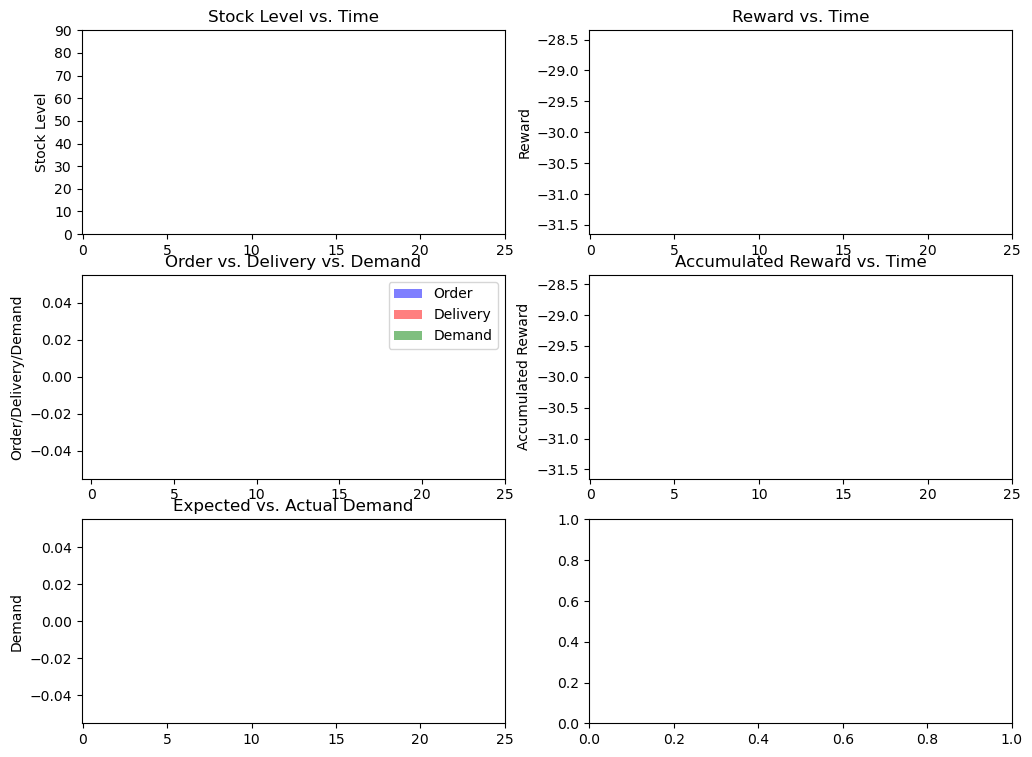

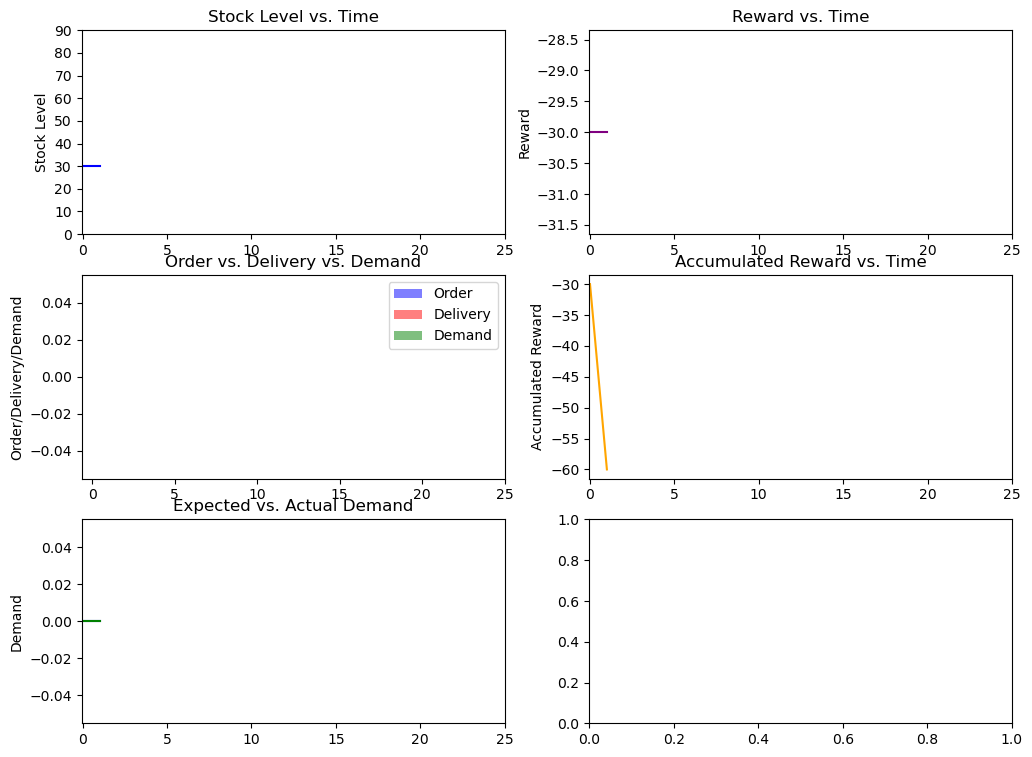

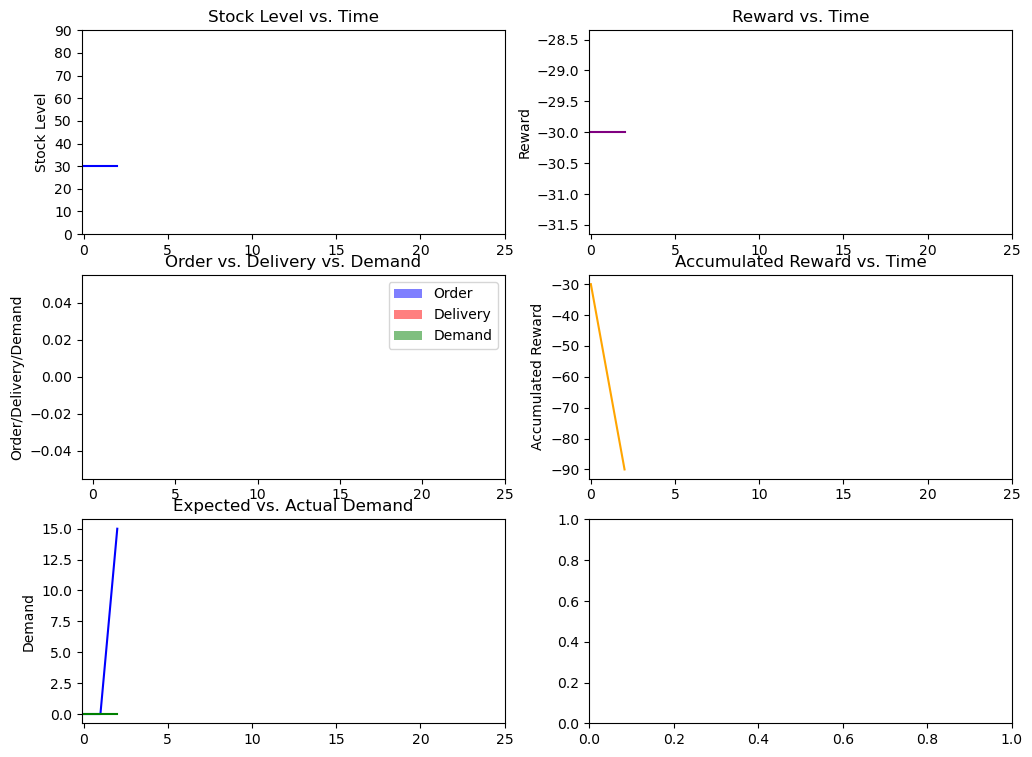

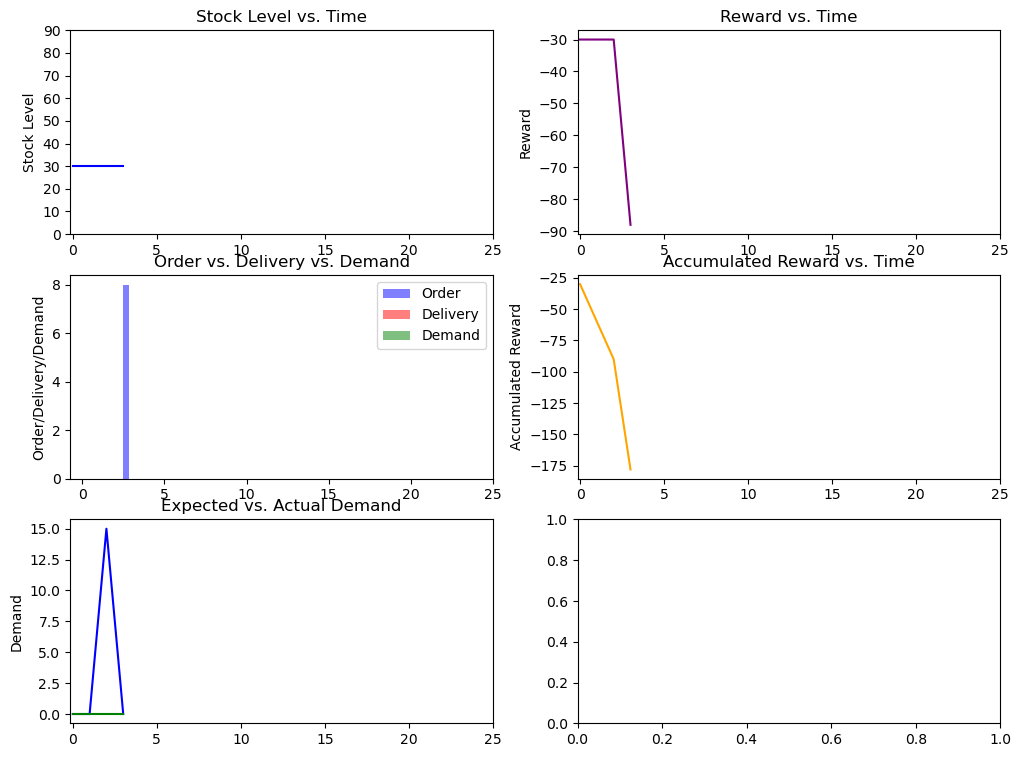

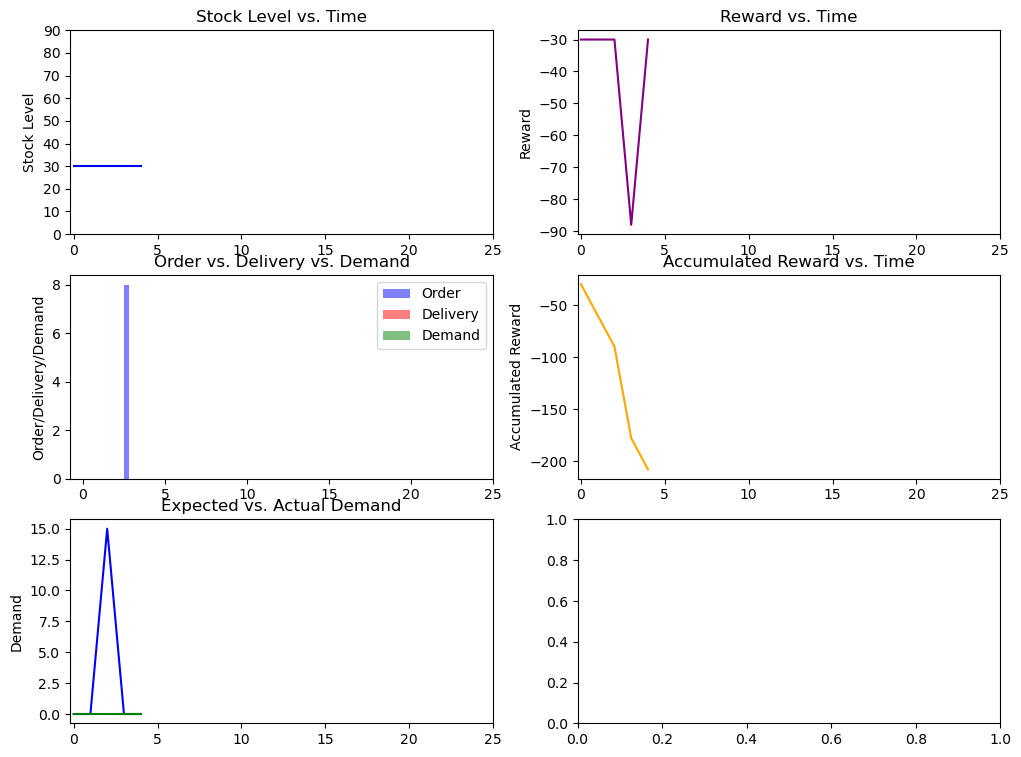

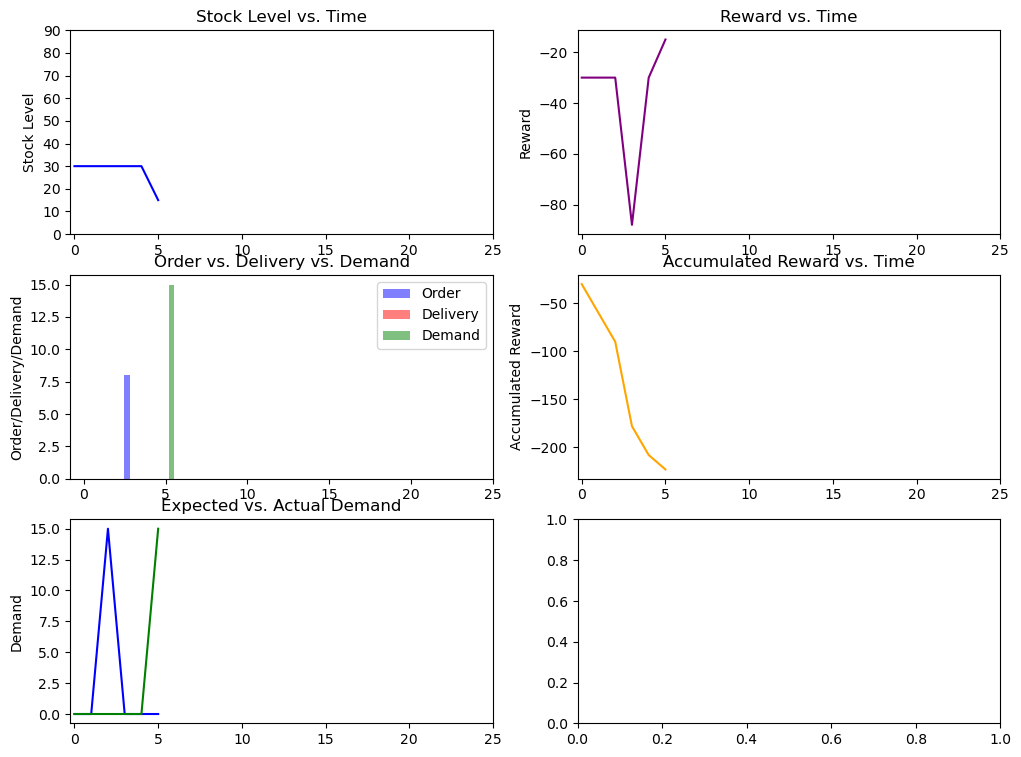

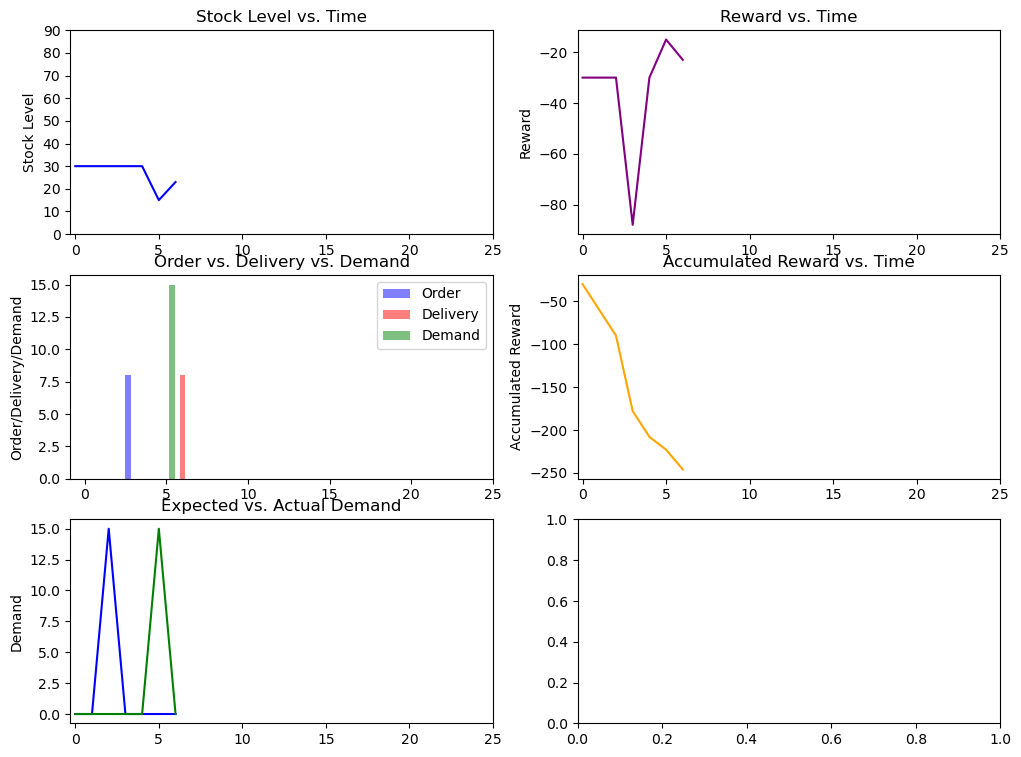

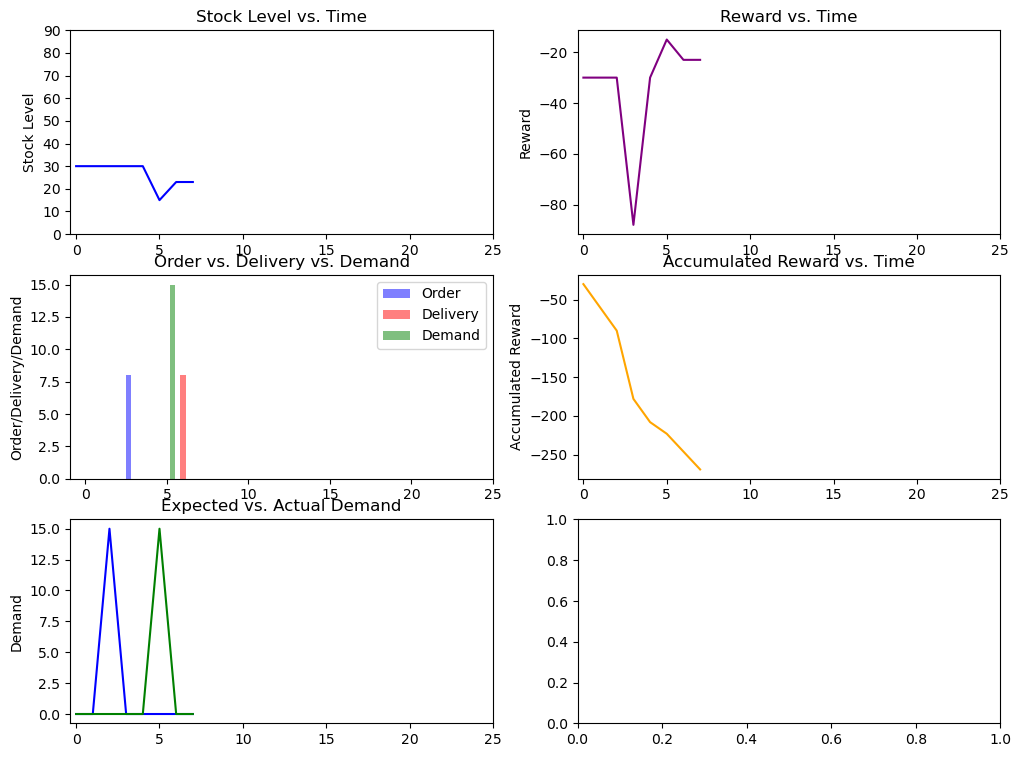

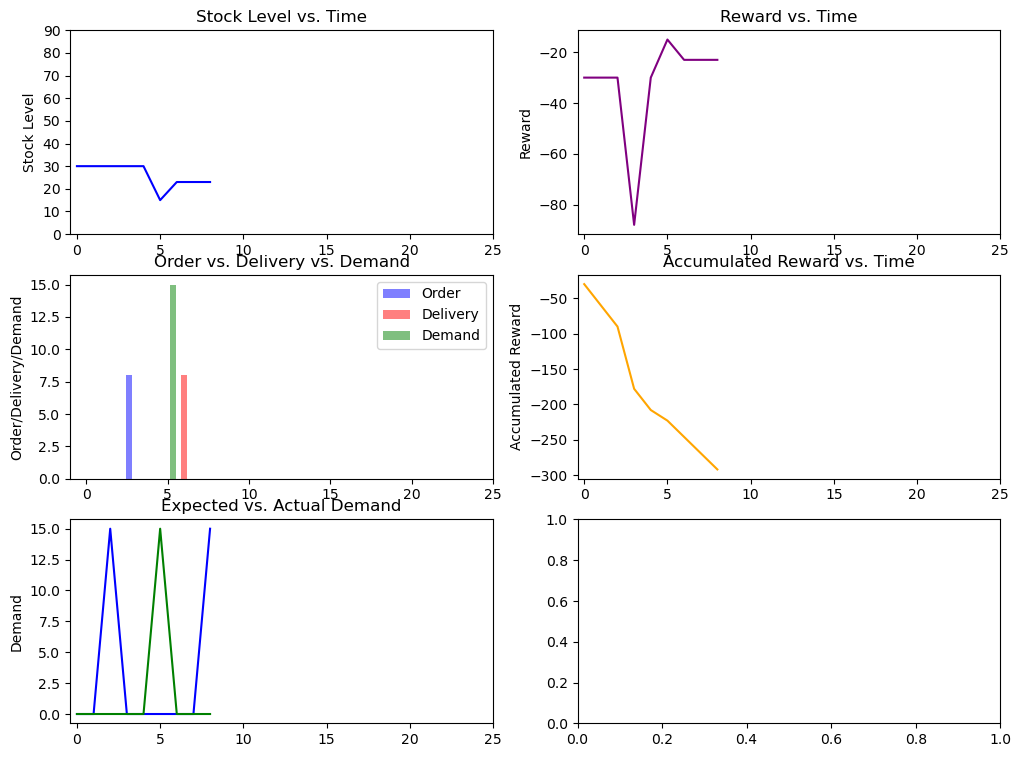

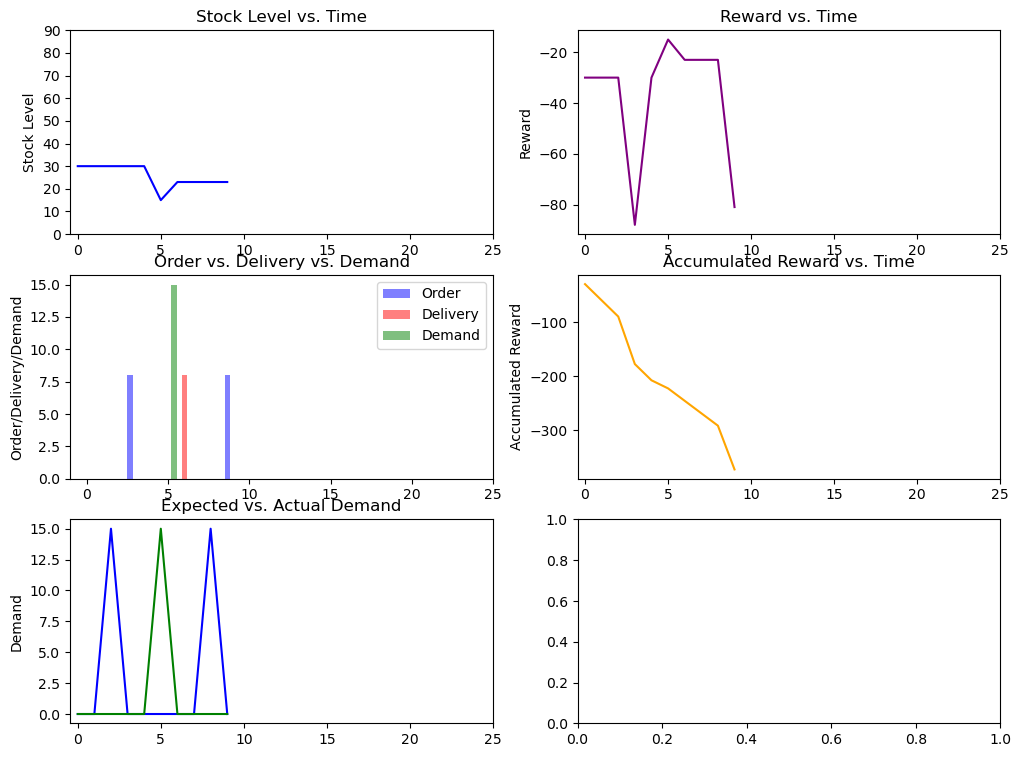

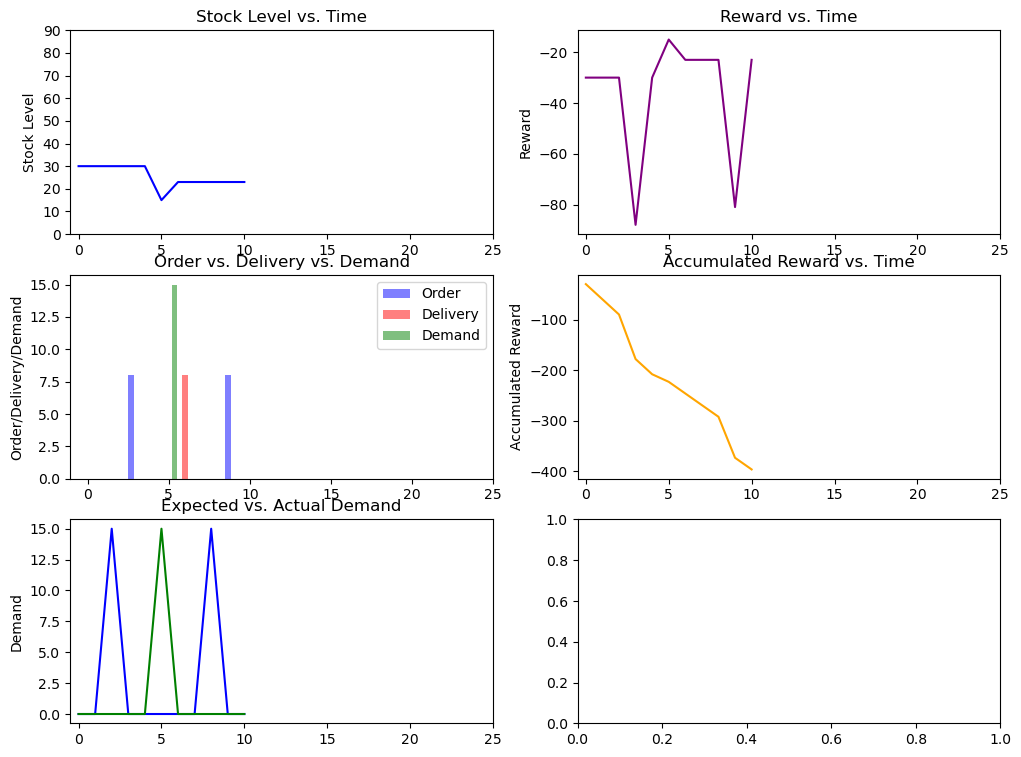

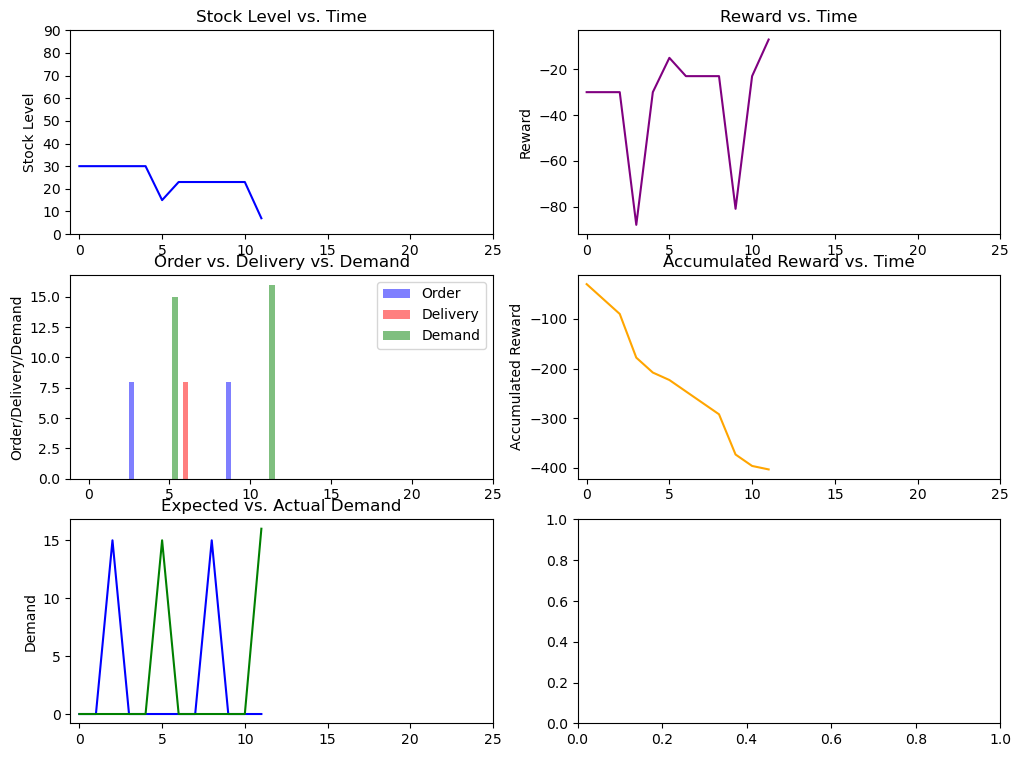

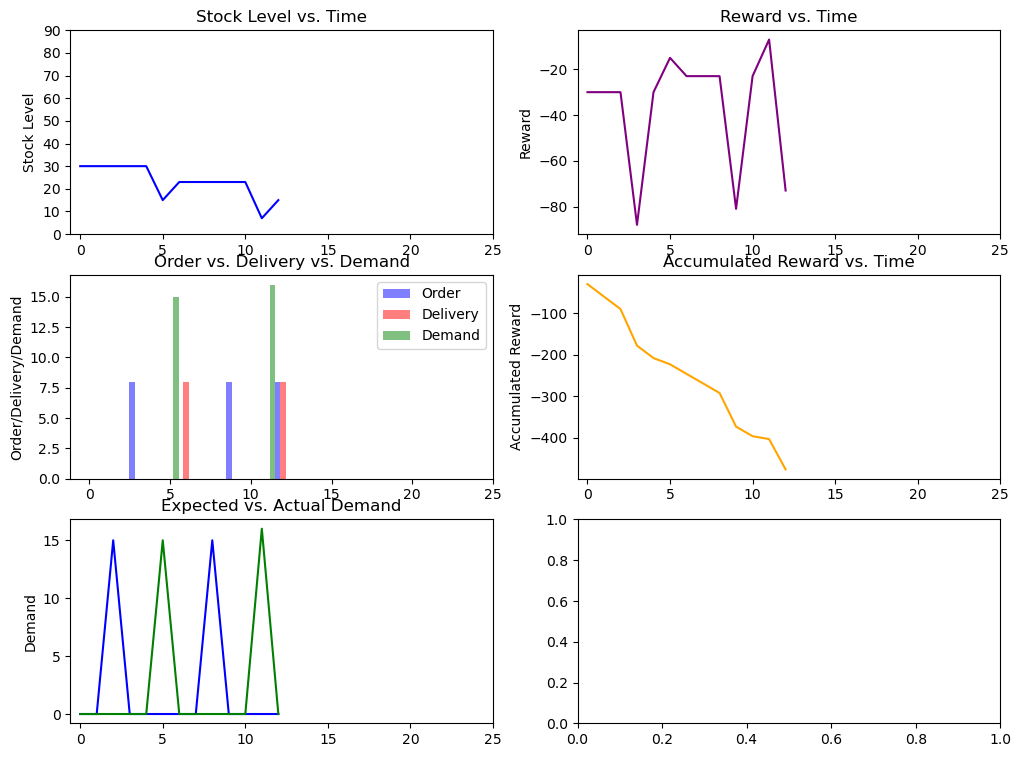

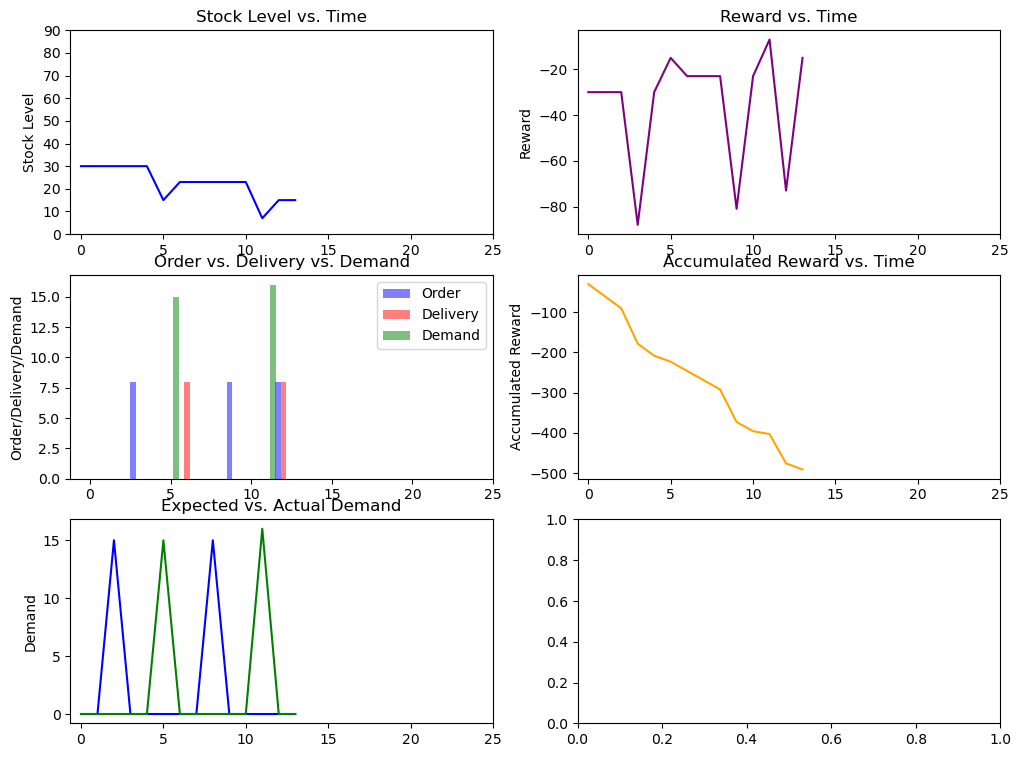

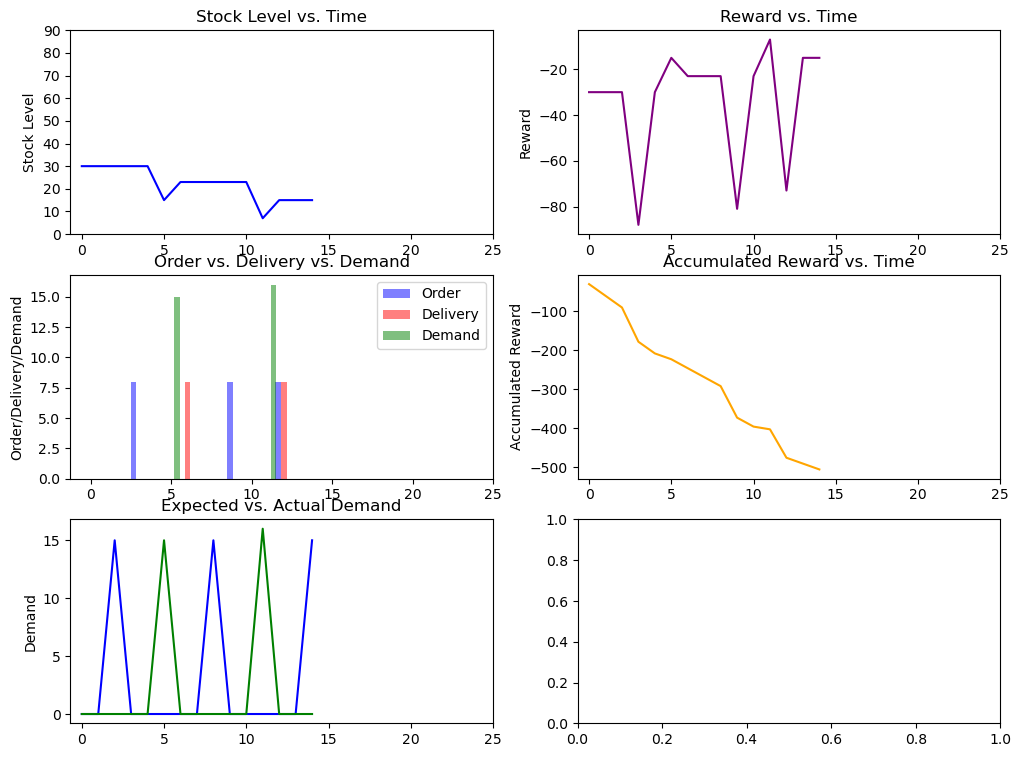

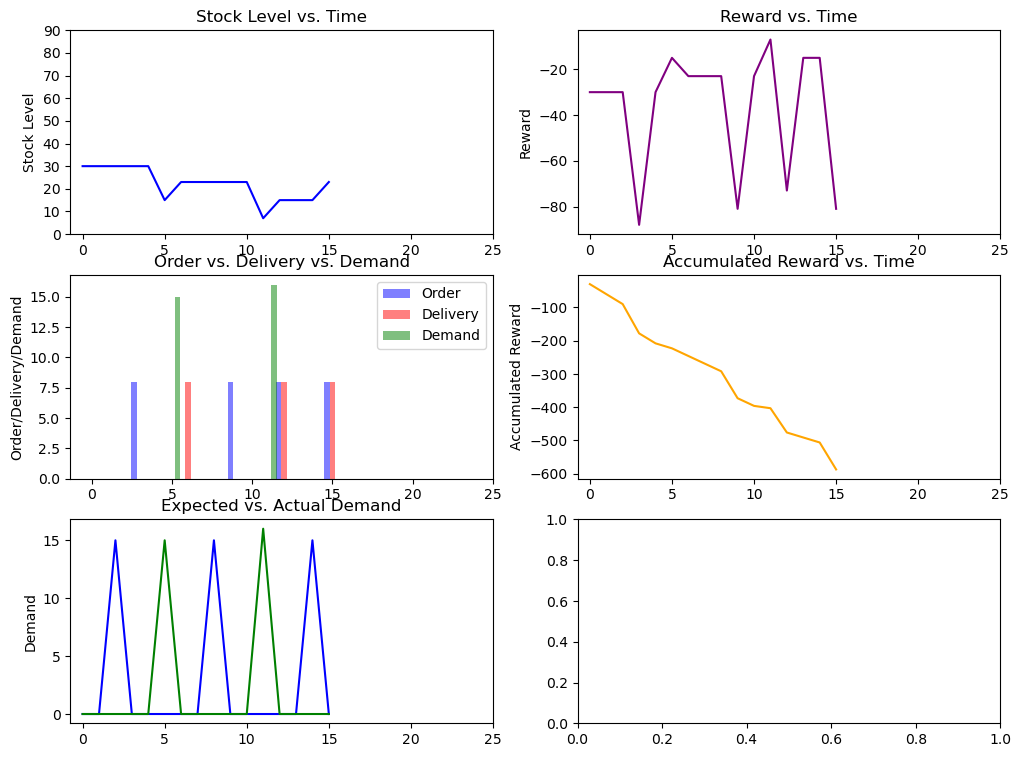

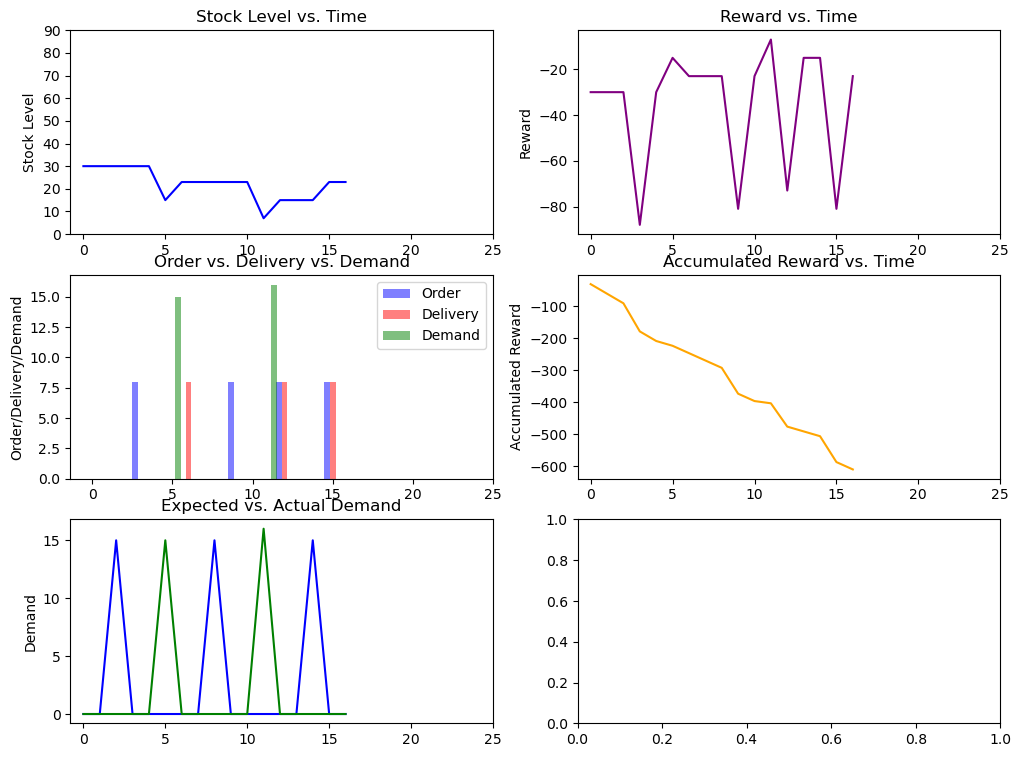

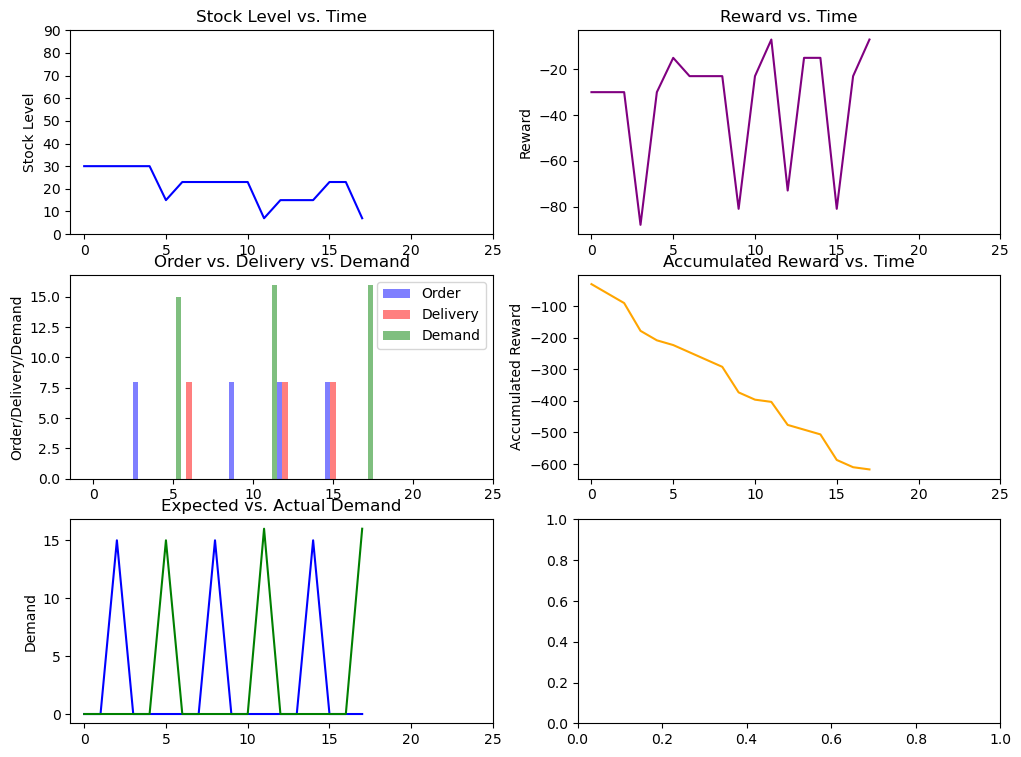

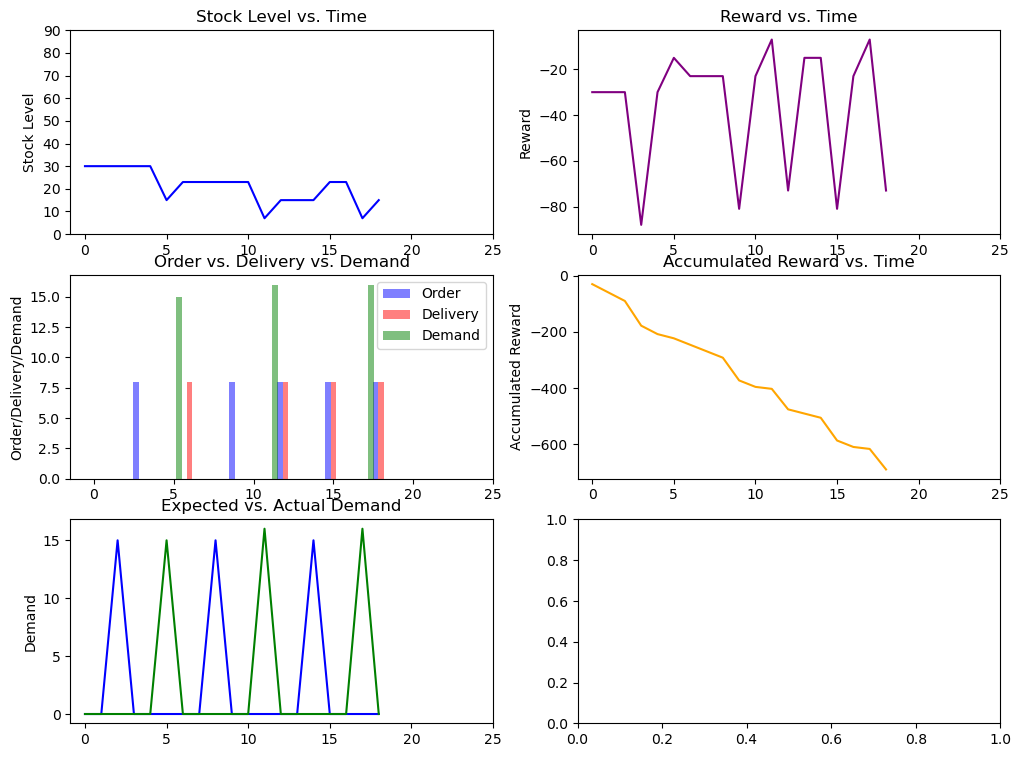

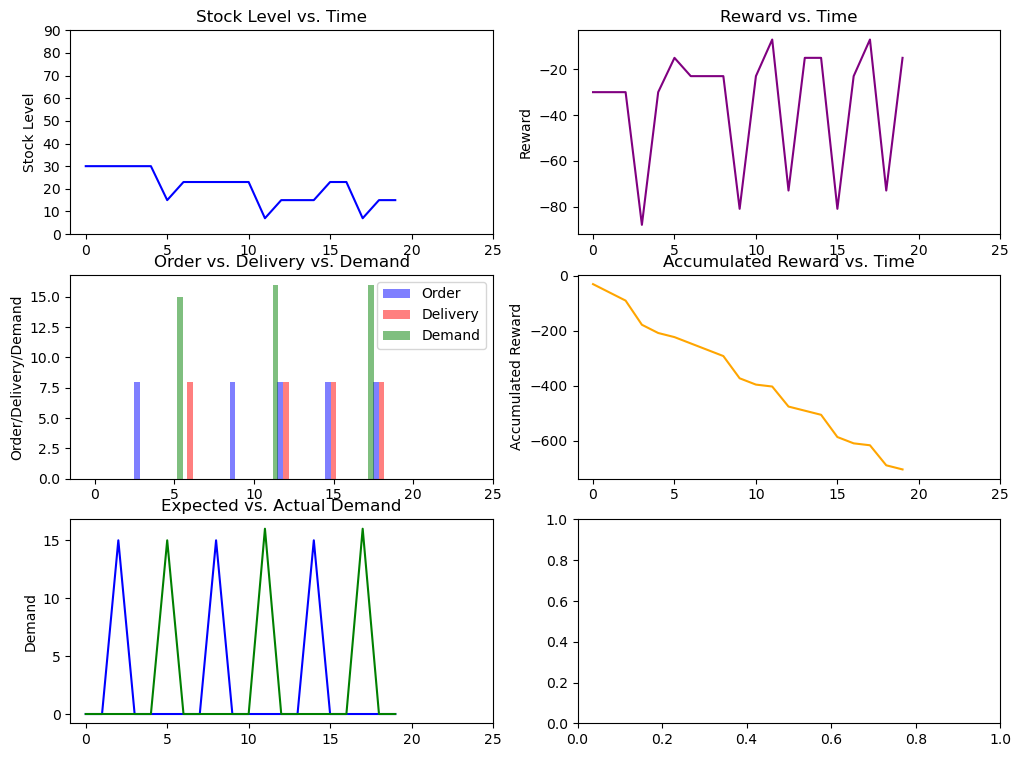

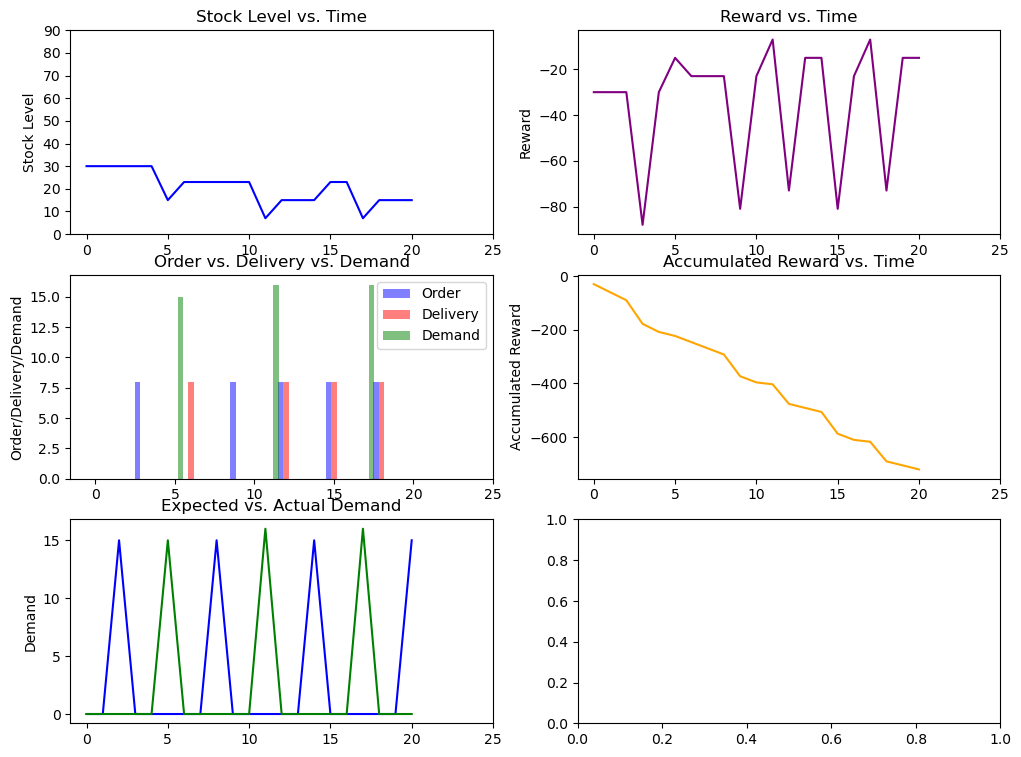

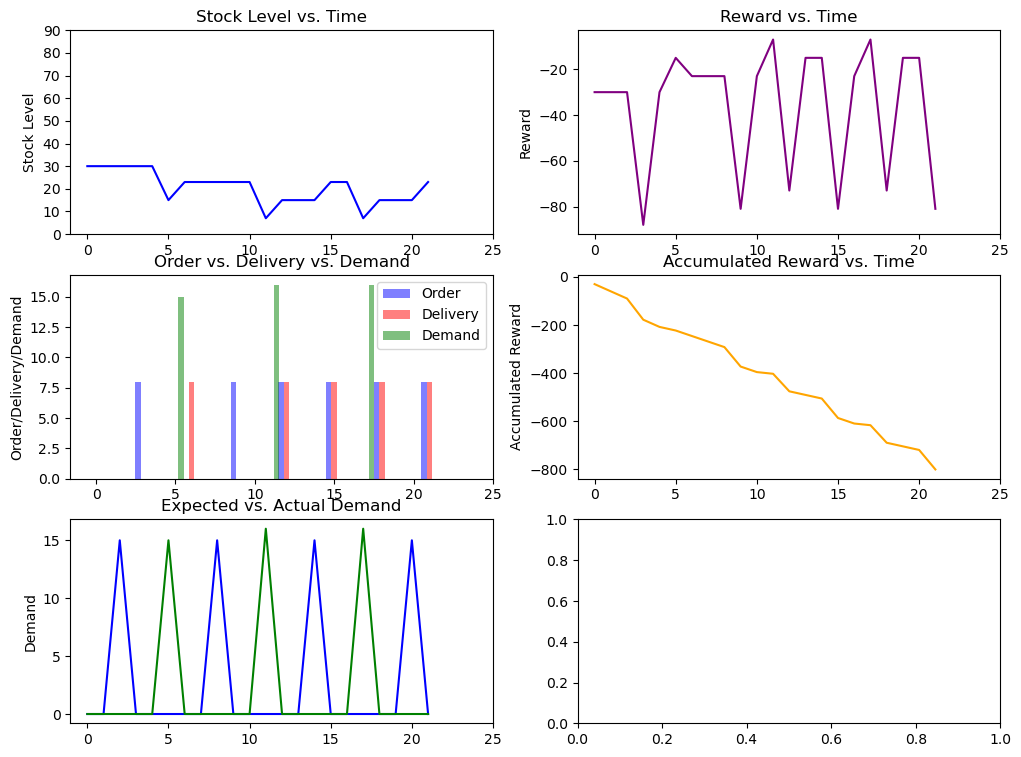

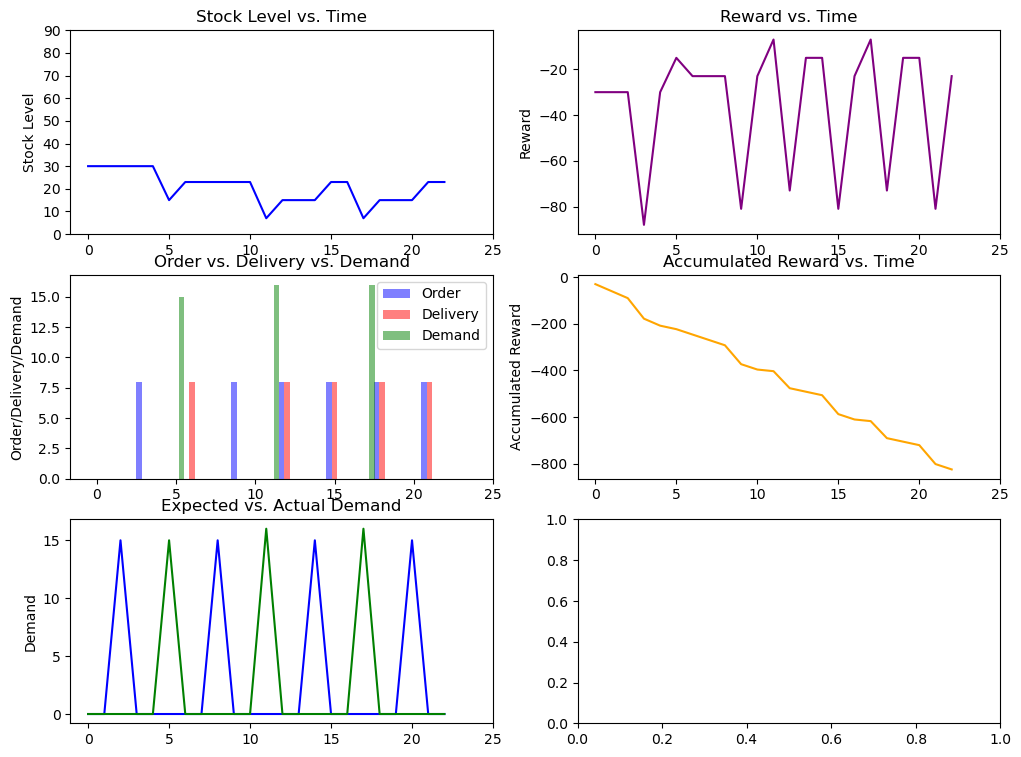

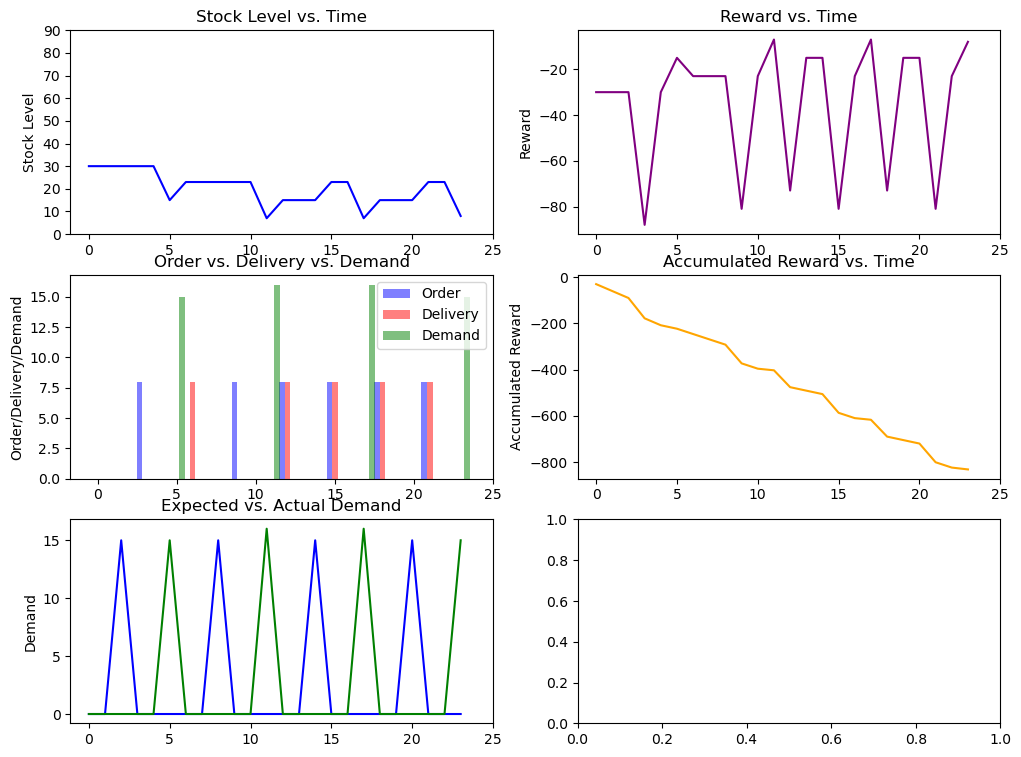

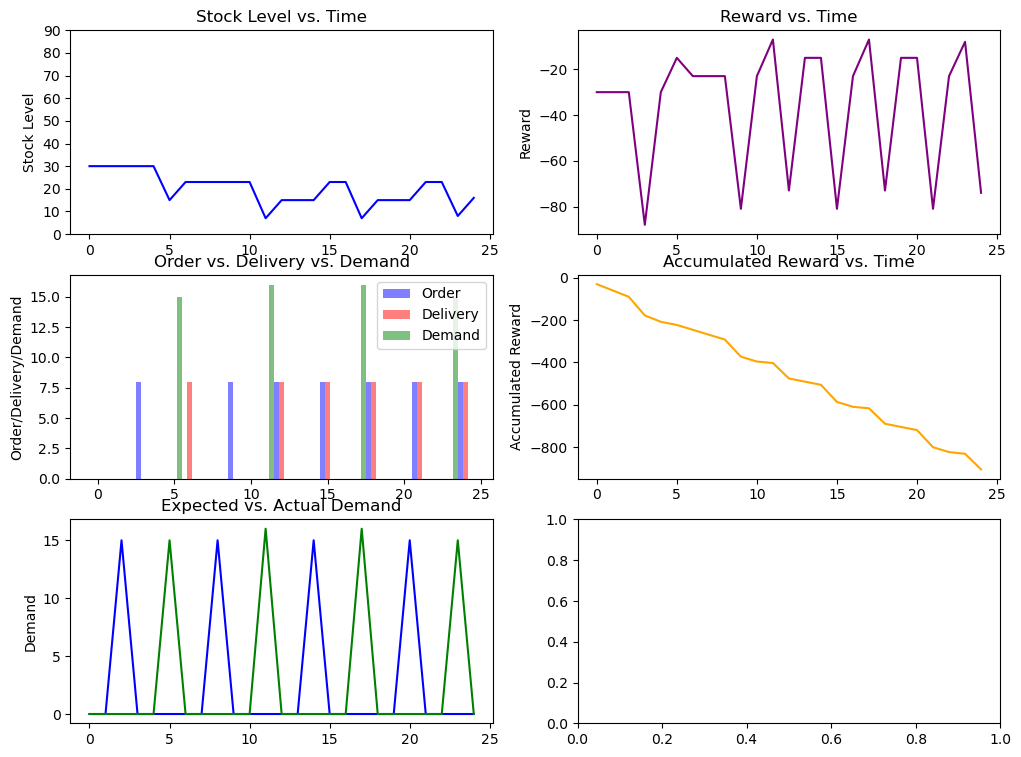

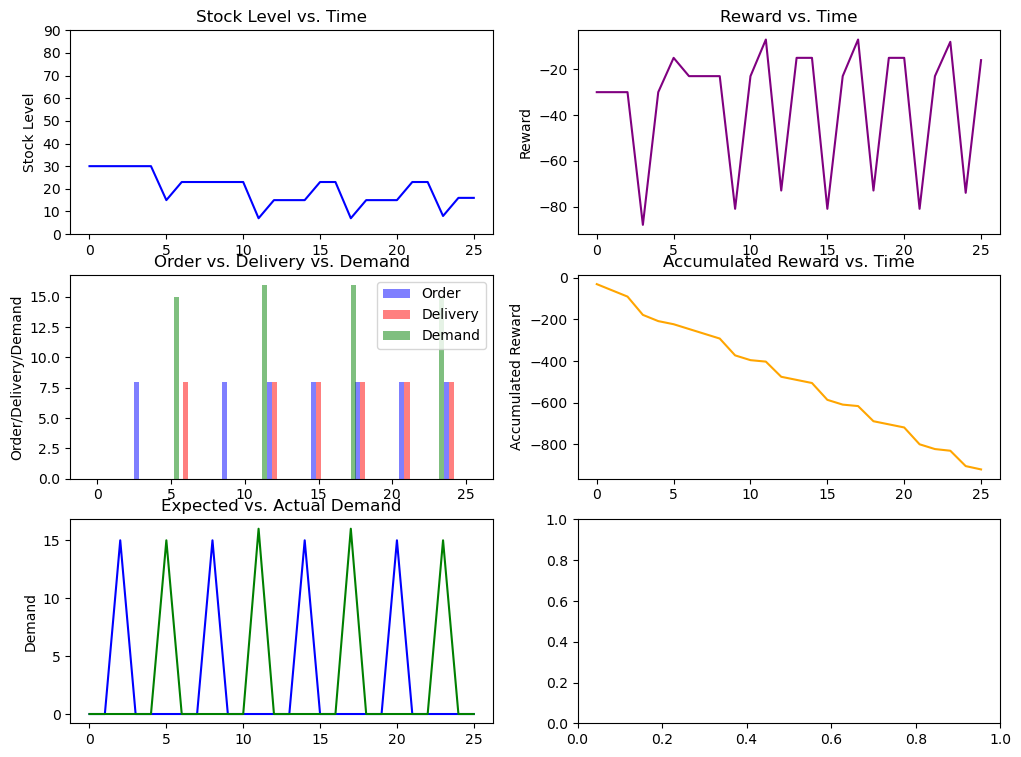

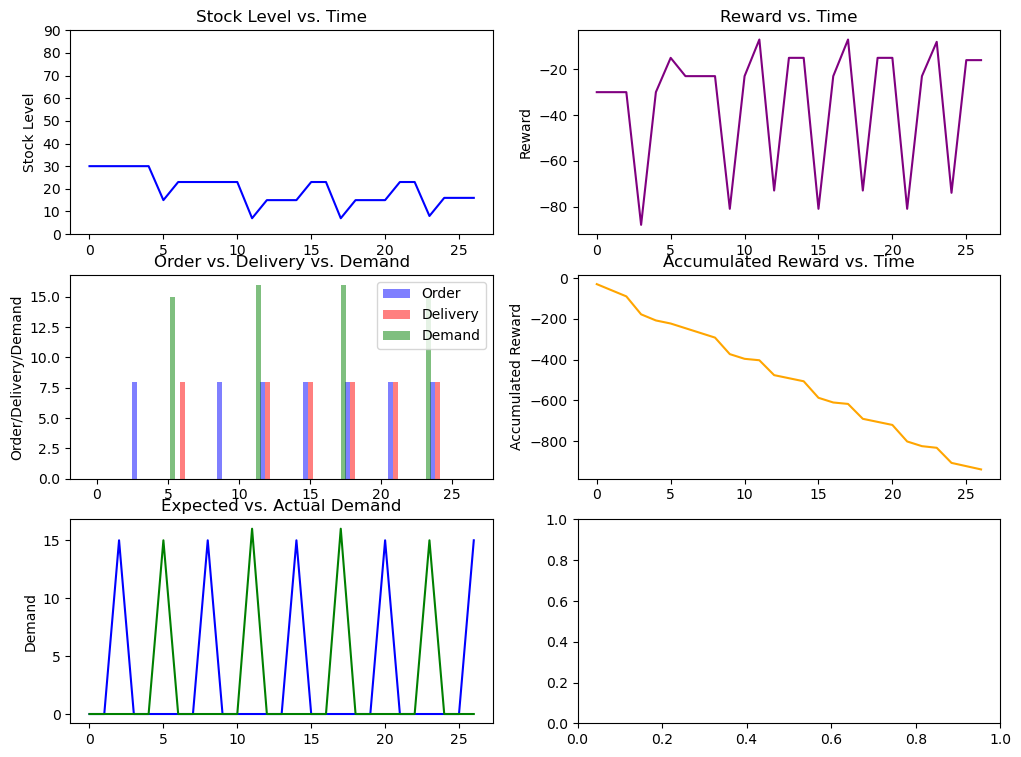

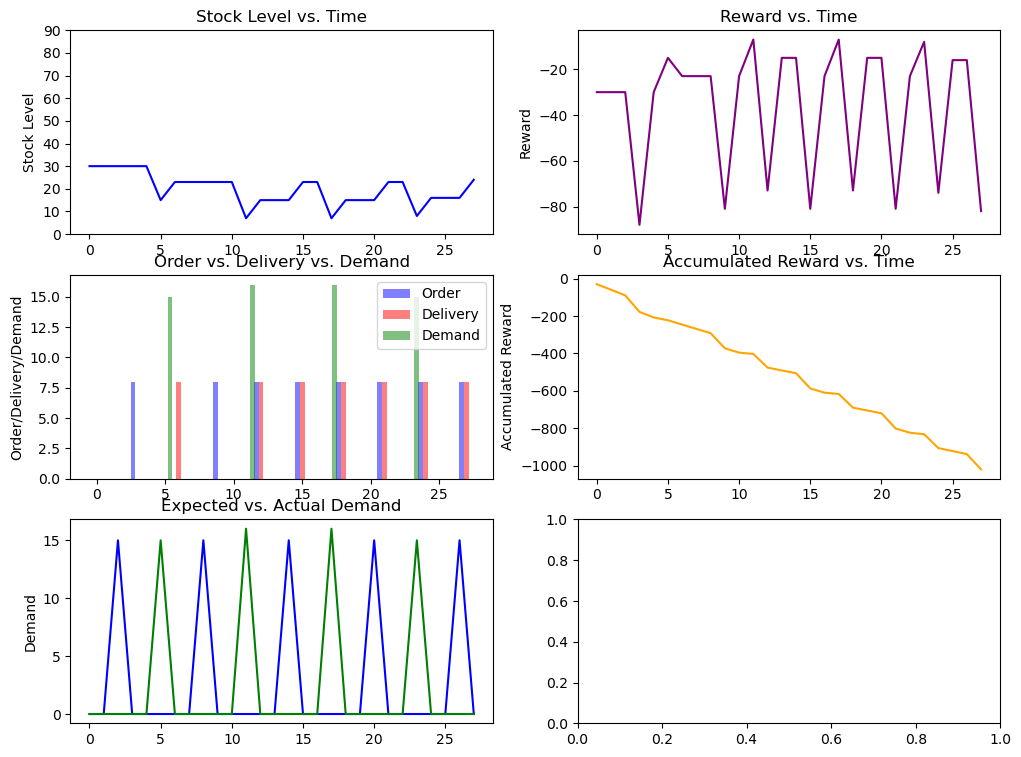

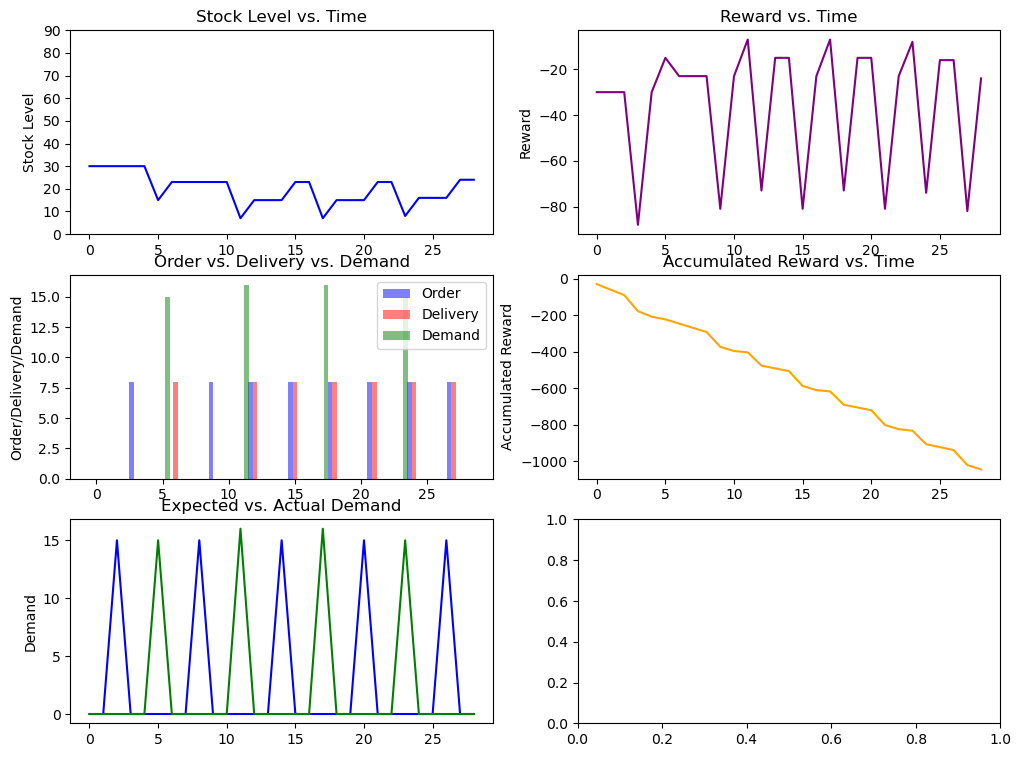

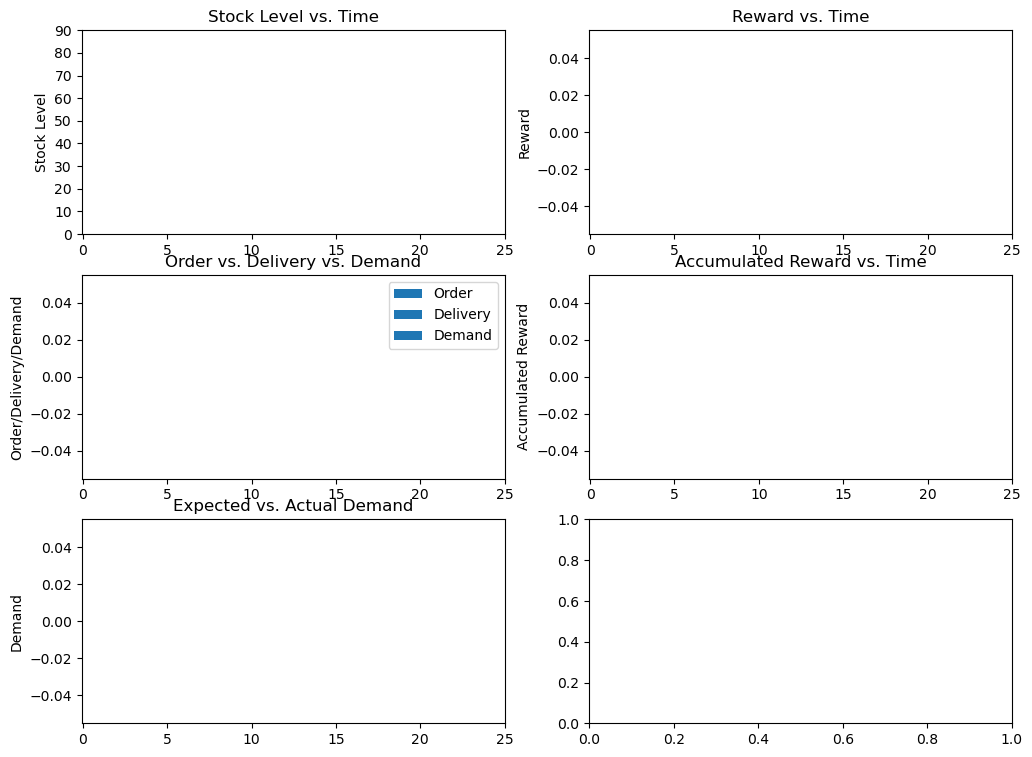

In [42]:
model = PPO.load(model_path, env = env)

env = SS_Mngmt_Env(render_mode="human")

evaluate_policy(model, env, n_eval_episodes=1, render=True, return_episode_rewards=True)

In [5]:
# predict the action based on the stock level
model.predict((30,), deterministic=True)

NameError: name 'model' is not defined